<h1> Binary classification </h1>

<hr>

<p> 
The present project intends to classify movie reviews as positive or negative, based on the text content of the reviews. 
</p>

<h2> The Dataset </h2>

<hr>

<p> The IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. </p>
<p> This dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary. </p>


In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

<p> We will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size. </p>

In [2]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [3]:
train_labels[0]

1

In [4]:
import numpy as np

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [5]:
max([max(sequence) for sequence in train_data])

9999

In [6]:
# word_index is a dictionary mapping words to an integer index.
word_index = imdb.get_word_index()

# Reverses it, mapping integer indices to words
reverse_word_index= dict(
    [(value, key) for (key, value) in word_index.items()]
)

# The indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown"
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]]
)

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

<h2> Preparing the Data </h2>

<hr>

<p> You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. </p>
<p> For that we will pad our lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors. </p>

In [8]:
from tensorflow.keras.utils import pad_sequences

In [9]:
max([len(sequence) for sequence in train_data])

2494

In [10]:
len(word_index)

88584

In [11]:
train_padded = pad_sequences(train_data, padding='post', maxlen=50)
test_padded = pad_sequences(test_data, padding='post', maxlen=50)

In [12]:
[len(sequence) for sequence in train_padded[:20]]

[50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50]

<h2> Building your network </h2>

<hr>

<p> A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with relu activations: Dense(16, activation='relu'). </p>
<p> The argument being passed to each Dense layer (16) is the number of hidden units of the layer. </p> 
<p> Having 16 hidden units means the weight matrix W will have shape (input_dimension, 16): the dot product with W will project the input data onto a 16-dimensional represen- tation space (and then you’ll add the bias vector b and apply the relu operation). Having more hidden units (a higher-dimensional representation space) allows your network to learn more-complex representations, but it makes the network more computationally expensive and may lead to learning unwanted patterns. </p>
<p> The intermediate layers will use relu as their activation function, and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1). </p>

In [13]:
from tensorflow.keras import Sequential, layers

In [14]:
vocab_size = 10000
embedding_dim = 16
max_length = 50

model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


<p> Because you’re facing a binary classification problem and the output of your network is a probability (you end your network with a single-unit layer with a sigmoid activation), it’s best to use the binary_crossentropy loss.Crossentropy is a quantity from the field of Infor- mation Theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions. </p>

<h2> Validating </h2>

<hr>

<p> In order to monitor during training the accuracy of the model on data it has never seen before, you’ll create a validation set by setting apart 10,000 samples from the original training data. </p>

In [15]:
x_val = train_padded[:10000]
partial_x_train = train_padded[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [16]:
x_val.shape

(10000, 50)

<h2> Training your model </h2>

<hr>

<p> The model is trained for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At the same time, the loss and accuracy are monitored on the 10,000 samples that you set apart. This is done by passing the validation data as the validation_data argument. </p>

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 7s 182ms/step - loss: 0.6913 - accuracy: 0.6038 - val_loss: 0.6885 - val_accuracy: 0.6757
Epoch 2/20
30/30 [==============================] - 4s 141ms/step - loss: 0.6839 - accuracy: 0.6893 - val_loss: 0.6794 - val_accuracy: 0.6965
Epoch 3/20
30/30 [==============================] - 3s 113ms/step - loss: 0.6705 - accuracy: 0.7250 - val_loss: 0.6642 - val_accuracy: 0.7158
Epoch 4/20
30/30 [==============================] - 4s 124ms/step - loss: 0.6492 - accuracy: 0.7491 - val_loss: 0.6417 - val_accuracy: 0.7309
Epoch 5/20
30/30 [==============================] - 2s 77ms/step - loss: 0.6199 - accuracy: 0.7769 - val_loss: 0.6138 - val_accuracy: 0.7545
Epoch 6/20
30/30 [==============================] - 2s 80ms/step - loss: 0.5849 - accuracy: 0.7920 - val_loss: 0.5825 - val_accuracy: 0.7693
Epoch 7/20
30/30 [==============================] - 3s 92ms/step - loss: 0.5463 - accuracy: 0.8098 - val_loss: 0.5504 - val_accuracy: 0.7768
Epoch 8/2

<p> The call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. </p>

In [18]:
history_dict = history.history

In [19]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<h2> Plotting the training and validation loss </h2>

<hr>



In [21]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [22]:
epochs = range(1, len(acc) + 1)
epochs

range(1, 21)

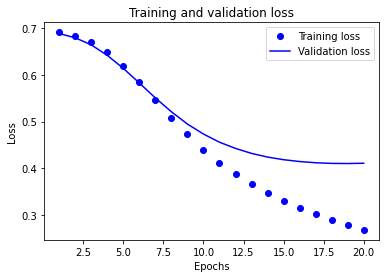

In [23]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

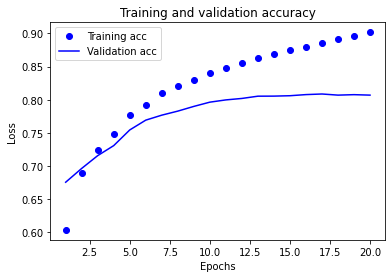

In [24]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h2> Generate predictions on new data </h2>

<hr>

<p> It is possible to generate the likelihood of reviews being positive by using the predict method. </p>

In [27]:
test_padded = pad_sequences(test_data, padding='post', maxlen=50)

In [29]:
test_padded.shape

(25000, 50)

In [31]:
model.predict(test_padded)

782/782 [==============================] - 1s 2ms/step


array([[0.12415216],
       [0.90912586],
       [0.76927906],
       ...,
       [0.27671462],
       [0.07919186],
       [0.632527  ]], dtype=float32)

<hr>